# Building an Expected Goals Model for Shot-Event Data

By Jayanth Nair, A Springboard Capstone Project

***Introduction***

The following table contains statistics from a very famous (or rather infamous) game of football, obtained from Christoph Biermann's book Football Hackers. It describes the game with conventional statistical metrics. 

|                             | Team A | Team B |
|-----------------------------|:------:|:------:|
|          Possession         |   52%  |   48%  |
| Passes into the 18 yard box |   19   |   11   |
|           Crosses           |   22   |   10   |
|           Corners           |    7   |    5   |
|      Dangerous attacks      |   55   |   34   |
|         Tackles won         |    5   |    1   |
|          Lost balls         |   69   |   76   |
|            Shots            |   18   |   14   |
|       Shots on Target       |   13   |   12   |

Upon first look, most people would conclude that Team A ran out comfortable winners. However, in reality Team B were the winners by some margin. These statistics are from the 2014 World Cup semi-final between Brazil and Germany. Team B were Germany. They won by 7 goals to 1.

Following the footsteps of baseball (Moneyball and more recently, Astroball) and basketball (Daryl Morey and the Houston Rockets), football/soccer is now undergoing a 'statistical revolution'. New statistical metrics are being developed which can quantify game scenarios better, thereby refining game tactics and player recruitment.

***What is Expected Goals?***

One of the relatively ubiquitous 'new' statistical metrics is Expected Goals (xG). xG essentially quantifies the quality of a shot by the probability of that shot being a goal. Intuitively, we know that a shot taken from outside the box is much less likely to be a goal than one being taken near the goal line. xG is a mere quantification of this intuitiveness. Some examples are below:

![Pavard Goal](https://media.giphy.com/media/jaJkRgaIT6wLayz5V7/giphy.gif)

This belter from Benjamin Pavard in the 2018 World Cup from outside the box will have a lower xG, while the goal below by Barcelona will have a much higher xG

![Barcelona Goal](https://media.giphy.com/media/zRqwfjscelwlO/giphy.gif)

***Why do we need xG?***

xG is an excellent predictor of how good a team is going forward, i.e attacking. The following is a snippet of the Premier League table on Nov 11, 2019 in descending order of points from Understat. (G is Goals scored and xG is, well, xG).

As you can see, the xG numbers match pretty well with the actual goals scored for each team, with some notable exceptions. Leicester City's attackers are ruthless in front of goal, outperforming their xG numbers significantly. Watford, Southampton and Manchester United on the other end seem to be underperforming as per their xG. 

![xGtable](https://i.imgur.com/LYwQilo.png)

Similary expected goals against or xGA can be used to quantify the quality of shots a team faces.  This can be used as an indicator of how good a team's defense is. Below is a table of goals allowed and xGA. At the top end of the table, Leicester and Sheffield United (!!!) seem to be outperforming their xGA numbers while Chelsea seem to be struggling.  The bottom three are all struggling with their defenses leaking goals. 

Both Watford and Southampton were at the receiving end of 0-6 and 0-9 maulings this season, so that will skew their numbers a little.

![xGatable](https://i.imgur.com/PWp0wQn.png)

***Objective***

My objective with this project is to create my own xG model. The dataset I am using is the [Statsbomb open dataset](https://github.com/statsbomb/open-data). Specifically, I will be using the women's soccer dataset which contains data from 2 seasons of the FA WSL, 1 season of NWSL and the 2018 women's world cup

The data contains 229 games and 5929 shots which should be sufficient to build a workable xG model

The approach will be hypothesis-driven. In any hypothesis driven approach, there needs to be a hypothesis tree which drives the data wrangling and exploration.  The hypothesis tree for this project is given below:

![decision_tree](https://imgur.com/wrmwByq.png)

Having done the EDA and statistical inference, it's time to do some final pre-processing on our data

### Step 1 - Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = 15
plt.style.use('fivethirtyeight')

/home/jayanth/anaconda3/envs/sklearn_venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Step 2 - Reading the pickled dataframe 

In [2]:
df = pd.read_pickle('./wrangled_dataframe.pkl')
df.head()

,shot_x,shot_y,shot_distance,shot_a,shot_b,shot_angle,timestamp,...,key_pass_type,key_pass_pattern,isCross,isCutback,preceding_event_player,preceding_event_team,statsbomb_xg
0,86.7,57.4,37.6,39.583456,35.894986,10.8,2019-12-06 00:04:36.133,...,None,None,False,False,Taylor Hinds,Everton LFC,0.013571
1,93.9,34.5,26.7,26.143068,27.775169,16.7,2019-12-06 00:04:40.569,...,None,None,False,False,Inessa Kaagman,Everton LFC,0.049914
2,95.8,47.1,25.2,26.624237,24.397746,17.3,2019-12-06 00:05:52.550,...,None,None,False,False,Abbey-Leigh Stringer,Birmingham City WFC,0.022202
3,109.6,54.5,17.8,21.222865,14.778701,15.4,2019-12-06 00:07:03.244,...,Ground Pass,From Throw In,False,False,Inessa Kaagman,Everton LFC,0.078857
4,95.0,44.8,25.5,26.503585,25.012797,17.6,2019-12-06 00:08:15.644,...,None,None,False,False,Hayley Ladd,Birmingham City WFC,0.031914


### Step 3 - Doing modifications to the dataframe based on statistical inference 

To make it easier to discern goals from shots which don't result in goals for plotting and other calculations, let's add two more columns to the dataframe - isGoal and isGoalBool

In [3]:
isGoal=[]
isGoalBool = []
for outcome in df['outcome_name'].values:
    if outcome=='Goal':
        isGoal.append('Goal')
        isGoalBool.append(1)
    else:
        isGoal.append('Not Goal')
        isGoalBool.append(0)

In [4]:
df['isGoal']=isGoal
df['isGoalBool']=isGoalBool

Let's condense the key_pass_type,isCross and isCutback features into 1 feature : cross_cutback_forward. This makes it easier to encode as a categorical feature later

In [5]:
cross_cutback_forward = []
for index, rows in df.iterrows():
    if rows['key_pass_type']=='None':
        cross_cutback_forward.append('none')
    else:
        if (rows['isCross']==False) and (rows['isCutback']==False):
            cross_cutback_forward.append('forward')
        elif rows['isCross']==True:
            cross_cutback_forward.append('cross')
        elif rows['isCutback']==True:
            cross_cutback_forward.append('cutback')

In [6]:
df['cross_cutback_forward']=cross_cutback_forward

In [7]:
df['cross_cutback_forward'].value_counts()

forward    3288
none       1835
cross       753
cutback      42
Name: cross_cutback_forward, dtype: int64

We are going to drop cutbacks because of the low sample size

In [8]:
df=df[df['cross_cutback_forward']!='cutback']
df['cross_cutback_forward'].value_counts()

forward    3288
none       1835
cross       753
Name: cross_cutback_forward, dtype: int64

Let's modify the key_pass_pattern feature similarly

In [9]:
df['key_pass_pattern'].value_counts()

None              1835
Regular Play      1515
From Throw In      827
From Corner        665
From Free Kick     515
From Counter       269
From Goal Kick     156
From Keeper         51
From Kick Off       34
Other                9
Name: key_pass_pattern, dtype: int64

Because of sample sizes, let's just group the samples into 'Regular Play','Non Regular Play' and 'None'

In [10]:
key_pass_pattern_list =[]
for index, rows in df.iterrows():
    if rows['key_pass_pattern']=='None':
        key_pass_pattern_list.append('none')
    else:
        if (rows['key_pass_pattern']=='Regular Play'):
            key_pass_pattern_list.append('Regular Play')
        else:
            key_pass_pattern_list.append('Non Regular Play') 

In [11]:
df['key_pass_pattern']=key_pass_pattern_list
df['key_pass_pattern'].value_counts()

Non Regular Play    2526
none                1835
Regular Play        1515
Name: key_pass_pattern, dtype: int64

Let's look at the type of play

In [12]:
df['type_name'].value_counts()

Open Play    5626
Free Kick     179
Penalty        70
Corner          1
Name: type_name, dtype: int64

Because of sample sizes, let's restric the model to only look at open play shots

In [13]:
df = df[df.type_name=='Open Play']
df.type_name.value_counts()

Open Play    5626
Name: type_name, dtype: int64

Statistical inference showed that time of shot or whether the shooter was playing home or away don't matter. So let's drop these columns

In [14]:
df=df.drop(['timestamp','home_or_away'],axis=1)
df.columns

Index(['shot_x', 'shot_y', 'shot_distance', 'shot_a', 'shot_b', 'shot_angle',
       'outcome_name', 'outcome_id', 'body_part_name', 'body_part_id',
       'technique_name', 'technique_id', 'type_name', 'type_id', 'first_time',
       'preceding_event', 'pack_density', 'shot_player', 'key_pass_type',
       'key_pass_pattern', 'isCross', 'isCutback', 'preceding_event_player',
       'preceding_event_team', 'statsbomb_xg', 'isGoal', 'isGoalBool',
       'cross_cutback_forward'],
      dtype='object')

There are some other redundant features which we should drop

In [15]:
df=df.drop(['shot_x','shot_y','shot_a','shot_b','outcome_name','body_part_id','outcome_id','technique_name','technique_id','type_name','type_id','preceding_event','shot_player','preceding_event_player','preceding_event_team','isCutback','isCross','isGoal'],axis=1)
df.columns

Index(['shot_distance', 'shot_angle', 'body_part_name', 'first_time',
       'pack_density', 'key_pass_type', 'key_pass_pattern', 'statsbomb_xg',
       'isGoalBool', 'cross_cutback_forward'],
      dtype='object')

Let's modify the 'first_time' feature

In [16]:
first_time_list =[]
for index, rows in df.iterrows():
    if rows['first_time']==True:
        first_time_list.append('first_time')
    else:
        first_time_list.append('carry')
df['first_time_or_carry']=first_time_list
df['first_time_or_carry'].value_counts()

carry         4466
first_time    1160
Name: first_time_or_carry, dtype: int64

In [17]:
df=df.drop(['first_time'],axis=1)
df.columns

Index(['shot_distance', 'shot_angle', 'body_part_name', 'pack_density',
       'key_pass_type', 'key_pass_pattern', 'statsbomb_xg', 'isGoalBool',
       'cross_cutback_forward', 'first_time_or_carry'],
      dtype='object')

Finally, let's modify the body_part_name feature

In [18]:
body_part_list=[]
for index, rows in df.iterrows():
    if (rows['body_part_name']=='Right Foot') or (rows['body_part_name']=='Left Foot'):
        body_part_list.append('Foot')
    elif (rows['body_part_name']=='Head'):
        body_part_list.append('Head')
    else:
        body_part_list.append('Other')

In [19]:
df['body_part_name']=body_part_list
df.body_part_name.value_counts()

Foot     4648
Head      967
Other      11
Name: body_part_name, dtype: int64

Since there are very few shots taken with a body part other than a head or a foot, let's drop these few shots

In [20]:
df=df[df.body_part_name != 'Other']
df.body_part_name.value_counts()

Foot    4648
Head     967
Name: body_part_name, dtype: int64

Finally let's check our final dataframe before we do any scaling or encoding

In [21]:
df.head()

,shot_distance,shot_angle,body_part_name,pack_density,key_pass_type,key_pass_pattern,statsbomb_xg,isGoalBool,cross_cutback_forward,first_time_or_carry
0,37.6,10.8,Foot,2,None,none,0.013571,0,none,carry
1,26.7,16.7,Foot,1,None,none,0.049914,0,none,first_time
2,25.2,17.3,Foot,2,None,none,0.022202,0,none,carry
3,17.8,15.4,Foot,1,Ground Pass,Non Regular Play,0.078857,1,forward,carry
4,25.5,17.6,Foot,6,None,none,0.031914,1,none,carry


In [22]:
df.isna().any()

shot_distance            False
shot_angle               False
body_part_name           False
pack_density             False
key_pass_type            False
key_pass_pattern         False
statsbomb_xg             False
isGoalBool               False
cross_cutback_forward    False
first_time_or_carry      False
dtype: bool

### Step 4 - Using Scikit-Learn to create a pipeline for encoding and scaling

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [24]:
#re-arranging column order
df =df[['shot_distance', 'shot_angle', 'body_part_name', 'pack_density',
       'key_pass_type', 'key_pass_pattern','cross_cutback_forward', 'first_time_or_carry','isGoalBool','statsbomb_xg']]

In [25]:
X = df.loc[:,df.columns!='isGoalBool']
y=df['isGoalBool']

In [26]:
X.head()

,shot_distance,shot_angle,body_part_name,pack_density,key_pass_type,key_pass_pattern,cross_cutback_forward,first_time_or_carry,statsbomb_xg
0,37.6,10.8,Foot,2,None,none,none,carry,0.013571
1,26.7,16.7,Foot,1,None,none,none,first_time,0.049914
2,25.2,17.3,Foot,2,None,none,none,carry,0.022202
3,17.8,15.4,Foot,1,Ground Pass,Non Regular Play,forward,carry,0.078857
4,25.5,17.6,Foot,6,None,none,none,carry,0.031914


In [27]:
y[:5]

0    0
1    0
2    0
3    1
4    1
Name: isGoalBool, dtype: int64

Since we have categorical and numerical columns let's use the ColumnTransformer to encode categorical columns and scale numerical columns

In [28]:
from sklearn.compose import ColumnTransformer

In [29]:
#intializing scaler and encoder
ohe=OneHotEncoder(sparse=False)
ss = StandardScaler()

#selecting categorical and numerical columns
cat_columns = ['body_part_name','key_pass_type','key_pass_pattern','cross_cutback_forward','first_time_or_carry']
num_columns = ['shot_distance','shot_angle','pack_density']

transformers = [('cat',ohe,cat_columns),('num',ss,num_columns)]

In [30]:
#using the passthrough option because we don't want to transform the statsbomb_xg column 
ct = ColumnTransformer(transformers,remainder='passthrough') 
X_t = ct.fit_transform(X)

Let's now split our data into training and test sets

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_t,y, test_size=0.3, stratify=y)

Since 'statsbomb_xg' is not a predictor feature, we can extract it and keep it aside for comparisons later. But we will delete it from our train and test feature matrices

In [33]:
train_statsbomb = X_train[:,-1]
test_statsbomb = X_test[:,-1]

In [34]:
X_train = np.delete(X_train,-1,axis=1)
X_test = np.delete(X_test,-1,axis=1)

### Step 5 - Finally, let's start trying out different models and benchmark their predictive performance

#### First, let's try logistic regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
#initializing a default logistic regression model and fitting to our training data
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's compare the performance of this off-the-shelf logistic regression model against the StatsBomb model on the training data

In [37]:
y_train_pred = log_reg.predict(X_train)
y_train_proba = log_reg.predict_proba(X_train)

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

In [39]:
def plot_roc_curve(y,y_model_proba,y_statsbomb_proba,model_label):
    fpr,tpr,thresholds = roc_curve(y,y_model_proba[:,1]) # extracting probability for positive class
    fpr_sb,tpr_sb,thresholds_sb = roc_curve(y,y_statsbomb_proba) # statsbomb_xg values
    plt.plot(fpr,tpr,label=model_label)
    plt.plot(fpr_sb,tpr_sb,label='statsbomb')
    plt.plot([0,1],[0,1])
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right');

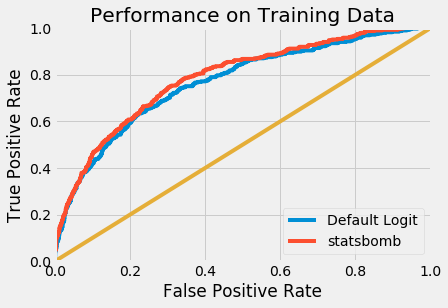

In [40]:
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Default Logit')
plt.title('Performance on Training Data');

In [41]:
print('The auc score for the logit model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),2)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

The auc score for the logit model on the training data is 0.77
The auc score for the Statsbomb model on the training data is 0.78


An off-the-shelf logistic regression model compares very well to the Statsbomb model on the training data. Let's see how it compares on the test data

The auc score for the logit model on the test data is 0.76
The auc score for the Statsbomb model on the test data is 0.8


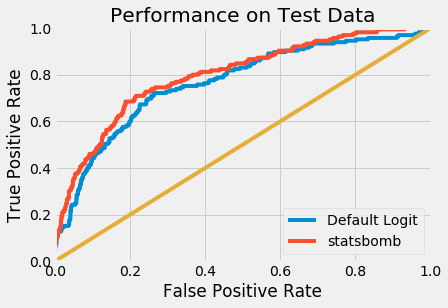

In [42]:
y_test_pred = log_reg.predict(X_test)
y_test_proba = log_reg.predict_proba(X_test)

plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Default Logit')
plt.title('Performance on Test Data');

print('The auc score for the logit model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),2)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

We can see that the performance is still pretty good on the test data. Let's do some hyper-parameter tuning to try and improve the performance

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100]}
gs_logit = GridSearchCV(LogisticRegression(),param_grid,scoring='roc_auc',cv=5)
gs_logit.fit(X_train,y_train)
gs_logit.best_params_

{'C': 0.1}

Let's extract the best estimator and calculate the AUC score on the test data

In [108]:
logit_best = gs_logit.best_estimator_
logit_best.fit(X_train,y_train)


y_test_proba = logit_best.predict_proba(X_test)
print('The auc score for the logit model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

The auc score for the logit model on the test data is 0.766
The auc score for the Statsbomb model on the test data is 0.8


The improvement is negligible but let's carry forward this estimator and look at what our precision recall curves and confusion matrix looks like

In [46]:
precisions,recalls,thresholds = precision_recall_curve(y_train,y_train_proba[:,1])

In [47]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    ''' From Hands On Machine Learning with Scikit-Learn and TensorFlow by 
    Aurelien Geron
    '''
    plt.plot(thresholds,precisions[:-1],label='Precision')
    plt.plot(thresholds,recalls[:-1],label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])

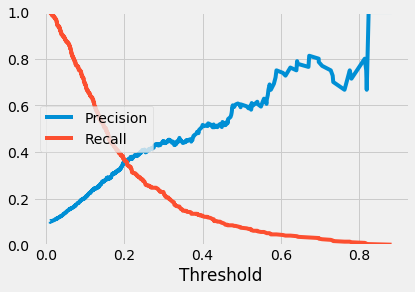

In [48]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

If we use a theshold of 0.5, we will get a low recall and high precision. We ideally, want to get a high recall as we want to classify all goals correctly. Let's use a threshold of 0.1 to compute the confusion matrix

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
predict_new = np.where(y_test_proba[:,1]>0.1,1,0)
print(confusion_matrix(y_test,predict_new))

[[1079  441]
 [  46  119]]


Because of precision-recall tradeoff, since we reduced the threshold to get high recall, it hurt our precision. But this is overall an acceptable model. Since the recall and precision scores are a function of the threshold, for model evaluation going forward, we will stick to the auc score

#### Next, let's try support vector machines

In [51]:
from sklearn.svm import SVC

In [52]:
#trying out the default SVC
svc_clf = SVC(probability=True) #gives us probabilities
svc_clf.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [53]:
y_train_proba = svc_clf.predict_proba(X_train)

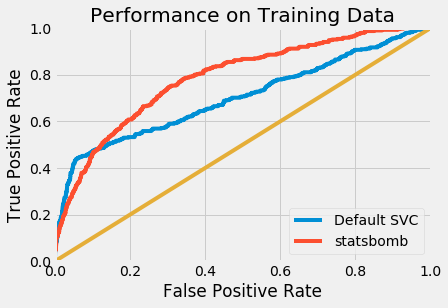

In [54]:
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Default SVC')
plt.title('Performance on Training Data');

In [55]:
print('The auc score for the SVM model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),2)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

The auc score for the SVM model on the training data is 0.7
The auc score for the Statsbomb model on the training data is 0.78


There is much room for improvement here. Let's do a grid search on the default SVC which has a polynomial kernel

In [56]:
param_grid = {'degree':[2,3], 'C':[0.001,0.01,0.1,1,10,100],'coef0':[0.001,0.01,0.1,1,10,100]}
gs_polysvc = GridSearchCV(SVC(probability=True),param_grid,cv=5,scoring='roc_auc')
gs_polysvc.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'coef0': [0.001, 0.01, 0.1, 1, 10, 100],
                         'degree': [2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [57]:
gs_polysvc.best_params_

{'C': 100, 'coef0': 0.001, 'degree': 2}

In [58]:
gs_best_polysvc = gs_polysvc.best_estimator_
gs_best_polysvc.fit(X_train,y_train)

y_test_proba = gs_best_polysvc.predict_proba(X_test)

The auc score for the Poly SVC model on the test data is 0.57
The auc score for the Statsbomb model on the test data is 0.8


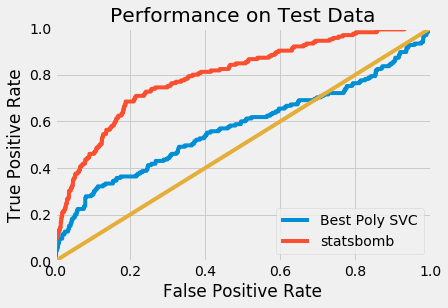

In [59]:
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best Poly SVC')
plt.title('Performance on Test Data');
print('The auc score for the Poly SVC model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),2)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

This is worse than the logistic regression model. Fortunately, we can try different kernels

In [60]:
#using rbf kernel
svc_rbf = SVC(kernel='rbf',probability=True)
svc_rbf.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

The auc score for the RBF SVC model on the test data is 0.7
The auc score for the Statsbomb model on the test data is 0.78


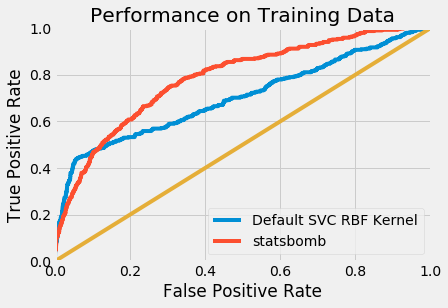

In [61]:
from sklearn.metrics import roc_auc_score
y_train_proba = svc_rbf.predict_proba(X_train)

plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Default SVC RBF Kernel')
plt.title('Performance on Training Data');

print('The auc score for the RBF SVC model on the test data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),2)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

In [62]:
param_grid = {'degree':[2,3], 'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100]}
gs_rbf = GridSearchCV(SVC(probability=True,kernel='rbf'),param_grid,cv=5,scoring='roc_auc')
gs_rbf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [2, 3],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [63]:
gs_rbf.best_score_

0.7457494550583408

In [64]:
svc_rbf_best = gs_rbf.best_estimator_
svc_rbf_best.fit(X_train,y_train)

y_test_proba = svc_rbf_best.predict_proba(X_test)

The auc score for the RBF SVC model on the test data is 0.75
The auc score for the Statsbomb model on the test data is 0.8


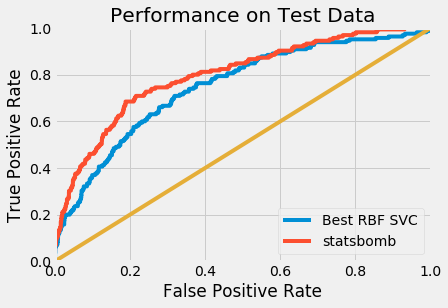

In [65]:
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best RBF SVC')
plt.title('Performance on Test Data');
print('The auc score for the RBF SVC model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),2)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

#### Next, let's try some tree based ensemble methods

In [66]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [67]:
#initializing a default baggingclassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_jobs=-1)

bag_clf.fit(X_train,y_train) 

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


The auc score for the Default Bagging model on the training data is 1.0
The auc score for the Statsbomb model on the training data is 0.78


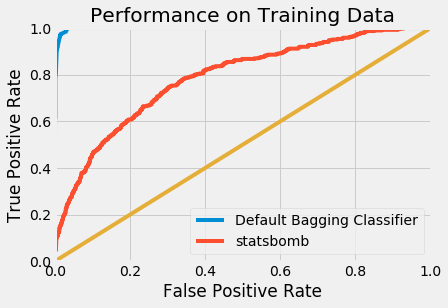

In [68]:
y_train_proba = bag_clf.predict_proba(X_train)
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Default Bagging Classifier')
plt.title('Performance on Training Data');

print('The auc score for the Default Bagging model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),2)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

This is a classic overfit because by default a bagging classifier initializes 10 estimators and each estimator takes a sample each. Let's conduct a gridsearch to find better hyper-parameters

In [71]:
param_grid = {'n_estimators':[10,100,500,1000,1500,2000],'max_samples':[10,100,500,1000]}
gs_bagging = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),n_jobs=-1),param_grid,cv=5,scoring='roc_auc')
gs_bagging.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                         

In [72]:
gs_bagging.best_params_

{'max_samples': 100, 'n_estimators': 1000}

In [73]:
best_bagging=gs_bagging.best_estimator_
best_bagging.fit(X_train,y_train)

y_test_proba = best_bagging.predict_proba(X_test)

The auc score for the Best Bagging model on the test data is 0.767
The auc score for the Statsbomb model on the test data is 0.8


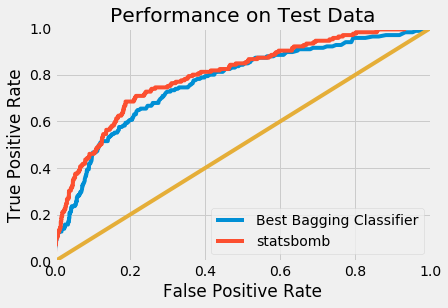

In [75]:
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best Bagging Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best Bagging model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

The best bagging classifier seems as good as the best logisitic regression model. But let's keep digging into other ensemble methods. Next up, random forests

In [76]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_jobs=-1)
rnd_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

The auc score for the Default Random Forest model on the training data is 0.999
The auc score for the Statsbomb model on the training data is 0.78


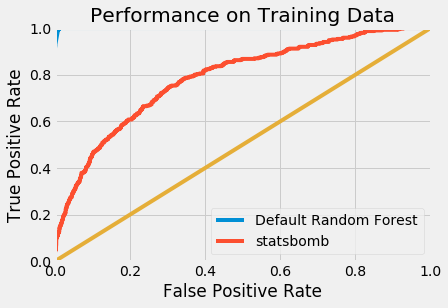

In [77]:
y_train_proba = rnd_clf.predict_proba(X_train)
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Default Random Forest')
plt.title('Performance on Training Data');

print('The auc score for the Default Random Forest model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

Again, the default classifier overfits. Let's do grid search again

In [78]:
X_train.shape

(3930, 17)

In [79]:
param_grid = {'n_estimators':[10,100,500,1000],'max_leaf_nodes':[10,15,20,25,30],'max_features':[5,10,15,'auto','log2',None]}
gs_rnd = GridSearchCV(RandomForestClassifier(n_jobs=-1),param_grid,cv=5,scoring='roc_auc')
gs_rnd.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

In [80]:
gs_rnd.best_params_

{'max_features': 10, 'max_leaf_nodes': 15, 'n_estimators': 500}

The auc score for the Best RF model on the test data is 0.768
The auc score for the Statsbomb model on the test data is 0.8


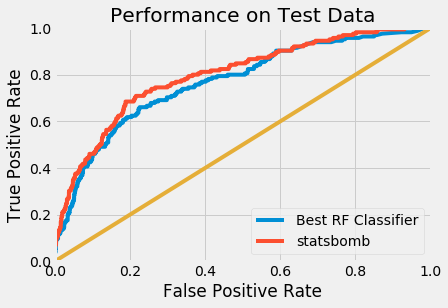

In [82]:
best_rnd = gs_rnd.best_estimator_
best_rnd.fit(X_train,y_train)

y_test_proba = best_rnd.predict_proba(X_test)

plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best RF Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best RF model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

This model seems pretty good too. Let's also try some boosting models

In [83]:
from sklearn.ensemble import AdaBoostClassifier

In [84]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                            algorithm='SAMME.R')
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

The auc score for the Default AdaBoost model on the training data is 0.797
The auc score for the Statsbomb model on the training data is 0.78


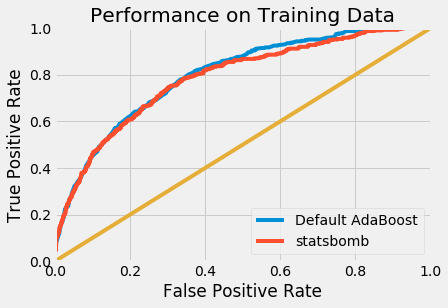

In [85]:
y_train_proba = ada_clf.predict_proba(X_train)
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Default AdaBoost')
plt.title('Performance on Training Data');

print('The auc score for the Default AdaBoost model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

The default AdaBoost seems to be a better fit to the training data than the StatsBomb model. But it could still be overfitting. Let's check the performance of this model on the test data

The auc score for the Default AdaBoost model on the test data is 0.757
The auc score for the Statsbomb model on the test data is 0.8


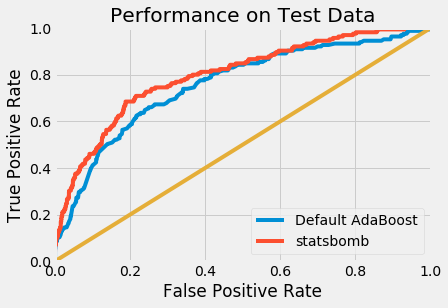

In [86]:
y_test_proba = ada_clf.predict_proba(X_test)
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Default AdaBoost')
plt.title('Performance on Test Data');

print('The auc score for the Default AdaBoost model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

It seems like it performs just as well as the best models we've created so far. Let's see if we can get some improvements using grid search

In [87]:
param_grid = {'n_estimators':[10,25,50,75,100,250,500,1000],'learning_rate':[0.1,0.25,0.5,1.0]}
gs_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm='SAMME.R'),param_grid,cv=5,scoring='roc_auc')
gs_ada.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
    

In [88]:
gs_ada.best_params_

{'learning_rate': 0.1, 'n_estimators': 50}

In [89]:
ada_best = gs_ada.best_estimator_
ada_best.fit(X_train,y_train)

y_test_proba = ada_best.predict_proba(X_test)

The auc score for the Best AdaBoost model on the test data is 0.764
The auc score for the Statsbomb model on the test data is 0.8


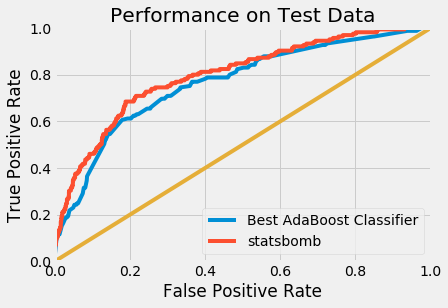

In [90]:
from sklearn.metrics import roc_auc_score
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best AdaBoost Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best AdaBoost model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

It seems GridSearch did not improve the performance significantly. Finally, let's do the GradientBoost classifier

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

In [92]:
gb_clf = GradientBoostingClassifier() #default GradientBoostingClassifier
gb_clf.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

The auc score for the Default GradientBoost model on the training data is 0.843
The auc score for the Statsbomb model on the training data is 0.78


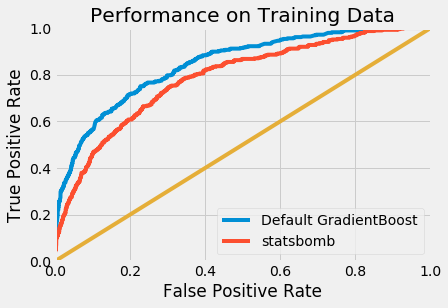

In [93]:
y_train_proba = gb_clf.predict_proba(X_train)
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Default GradientBoost')
plt.title('Performance on Training Data');

print('The auc score for the Default GradientBoost model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

The default GradientBoost model also works very well on the training data. Let's check it's performance on test data

The auc score for the Default GradientBoost model on the test data is 0.759
The auc score for the Statsbomb model on the test data is 0.8


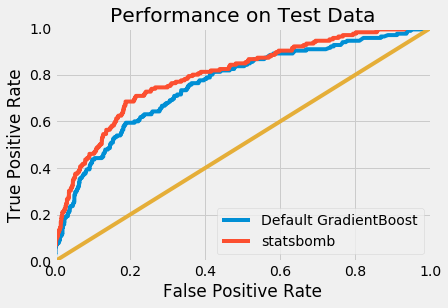

In [94]:
y_test_proba = gb_clf.predict_proba(X_test)
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Default GradientBoost')
plt.title('Performance on Test Data');

print('The auc score for the Default GradientBoost model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

Let's do some grid searching to optimize the performance of this model

In [95]:
param_grid={'max_depth':[1,2,3],'n_estimators':[10,25,50,75,100,250,500,1000],'learning_rate':[0.1,0.25,0.5,1.0],'subsample':[0.1,0.25,0.5,1.0],
           'warm_start':[True,False]}
gs_gb = GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5,scoring='roc_auc')
gs_gb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [96]:
gs_gb.best_params_

{'learning_rate': 0.25,
 'max_depth': 1,
 'n_estimators': 100,
 'subsample': 0.5,
 'warm_start': False}

In [97]:
best_gb = gs_gb.best_estimator_
best_gb.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [98]:
y_test_proba = best_gb.predict_proba(X_test)

The auc score for the Best GradientBoost model on the test data is 0.773
The auc score for the Statsbomb model on the test data is 0.8


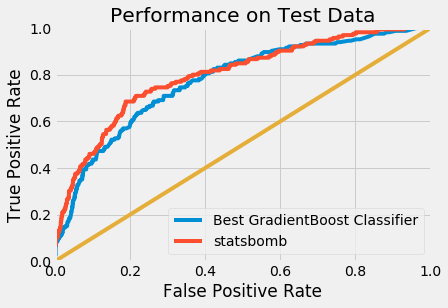

In [99]:
from sklearn.metrics import roc_auc_score
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best GradientBoost Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best GradientBoost model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

#### Next, let's try KNearestNeighbors

In [100]:
from sklearn.neighbors import KNeighborsClassifier

In [101]:
knn_clf = KNeighborsClassifier() #default

In [102]:
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

The auc score for the Default KNearestNeighbors model on the training data is 0.916
The auc score for the Statsbomb model on the training data is 0.78


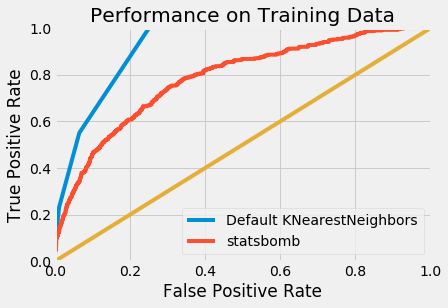

In [103]:
y_train_proba = knn_clf.predict_proba(X_train)
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Default KNearestNeighbors')
plt.title('Performance on Training Data');

print('The auc score for the Default KNearestNeighbors model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

There is clear overfitting here. Let's do grid search

In [104]:
param_grid={'n_neighbors':[20,30,40,50,60,70,80,90,100],'weights':['uniform','distance'],'algorithm':['auto','ball_tree','kd_tree','brute'],
           'p':[1,2]}
gs_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1),param_grid,cv=5,scoring='roc_auc')
gs_knn.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [105]:
gs_knn.best_params_

{'algorithm': 'brute', 'n_neighbors': 90, 'p': 1, 'weights': 'uniform'}

In [106]:
knn_best = gs_knn.best_estimator_
knn_best.fit(X_train,y_train)

y_test_proba = knn_best.predict_proba(X_test)

The auc score for the Best KNN model on the test data is 0.758
The auc score for the Statsbomb model on the test data is 0.8


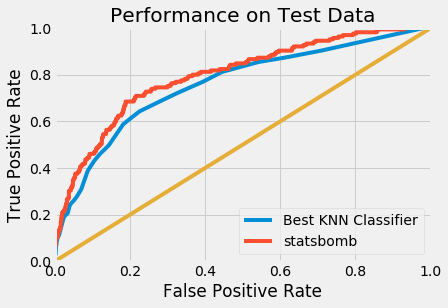

In [107]:
from sklearn.metrics import roc_auc_score
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best KNN Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best KNN model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

#### Let's try xgboost

In [109]:
import xgboost as xgb

In [110]:
data_dmatrix_training = xgb.DMatrix(data=X_train,label=y_train)

In [111]:
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

The auc score for the Default xgboost model on the training data is 0.829
The auc score for the Statsbomb model on the training data is 0.78


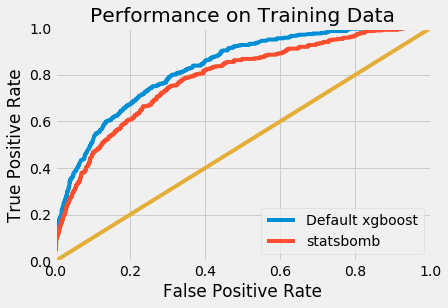

In [112]:
y_train_proba = xg_clf.predict_proba(X_train)
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Default xgboost')
plt.title('Performance on Training Data');

print('The auc score for the Default xgboost model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

In [119]:
param_grid = {'n_estimators':[50,100,250,500],'learning_rate':[0.1,0.25],'max_depth':[1,2,3],
             'subsample':[0.25,0.5,0.75], 'colsample_bytree':[0.1,0.5,1]}
gs_xgb = GridSearchCV(xgb.XGBClassifier(n_jobs=-1,),param_grid,cv=5,scoring='roc_auc')
gs_xgb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.1, 0.5, 1],
                         'learning_rate': [0.1, 0.25], 'max_depth': [1, 2, 3],
                         'n_estimator

In [120]:
gs_xgb.best_params_

{'colsample_bytree': 0.1,
 'learning_rate': 0.1,
 'max_depth': 1,
 'n_estimators': 500,
 'subsample': 0.75}

In [121]:
best_xgb = gs_xgb.best_estimator_
best_xgb.fit(X_train,y_train)


y_test_proba = best_xgb.predict_proba(X_test)

The auc score for the Best XGB model on the test data is 0.775
The auc score for the Statsbomb model on the test data is 0.8


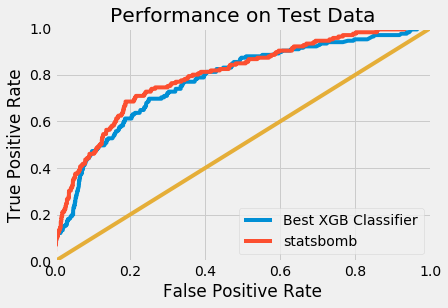

In [122]:
from sklearn.metrics import roc_auc_score
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best XGB Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best XGB model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

Based on the auc scores on the test data, the xgb model seems to be the best performing one